In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.append(os.path.join(os.path.abspath(''), '../'))

In [3]:
from dotenv import load_dotenv
load_dotenv()

import asyncio

from computer_use_demo.loop import sampling_loop, PROVIDER_TO_DEFAULT_MODEL_NAME, APIProvider, SYSTEM_PROMPT
import os

from playwright.async_api import async_playwright

In [4]:
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless=False)
page = await browser.new_page(viewport={"width": 1024, "height": 768})

In [5]:
messages = []

In [6]:
from computer_use_demo.utils.print_utils import noop
from computer_use_demo.utils.conversation_utils import display_conversation_markdown


def print_diff(old_messages, new_messages):
    # old_messages_set = set(old_messages)
    messages_to_print = [
        message for message in new_messages if message not in old_messages
    ]
    display_conversation_markdown(messages_to_print)
    old_messages.extend(messages_to_print)
            
async def converse():
    old_messages = [*messages]
    try:
        await sampling_loop(
                model=PROVIDER_TO_DEFAULT_MODEL_NAME[APIProvider.ANTHROPIC],
                api_key=os.environ.get("ANTHROPIC_API_KEY", ""),
                provider=APIProvider.ANTHROPIC,
                messages=messages,
                system_prompt_suffix="",
                output_callback=lambda _: print_diff(old_messages, messages),
                tool_output_callback=lambda _, __: print_diff(old_messages, messages),
                api_response_callback=noop,
                page=page,
            )
    except Exception as e:
        import traceback
        traceback.print_exc()
    await asyncio.sleep(0.1)

#### 🤖 Assistant

I'll help you look up the atomic number for iron on Wikipedia. Let me navigate to Wikipedia and search for iron.

🛠 Tool use:
- **Name**: `playwright`
- **Input**: `{'action': '{"type": "goto", "url": "https://en.wikipedia.org/wiki/Iron"}'}`



---



#### 🧑 User

Tool result:

Navigated to page https://en.wikipedia.org/wiki/Iron

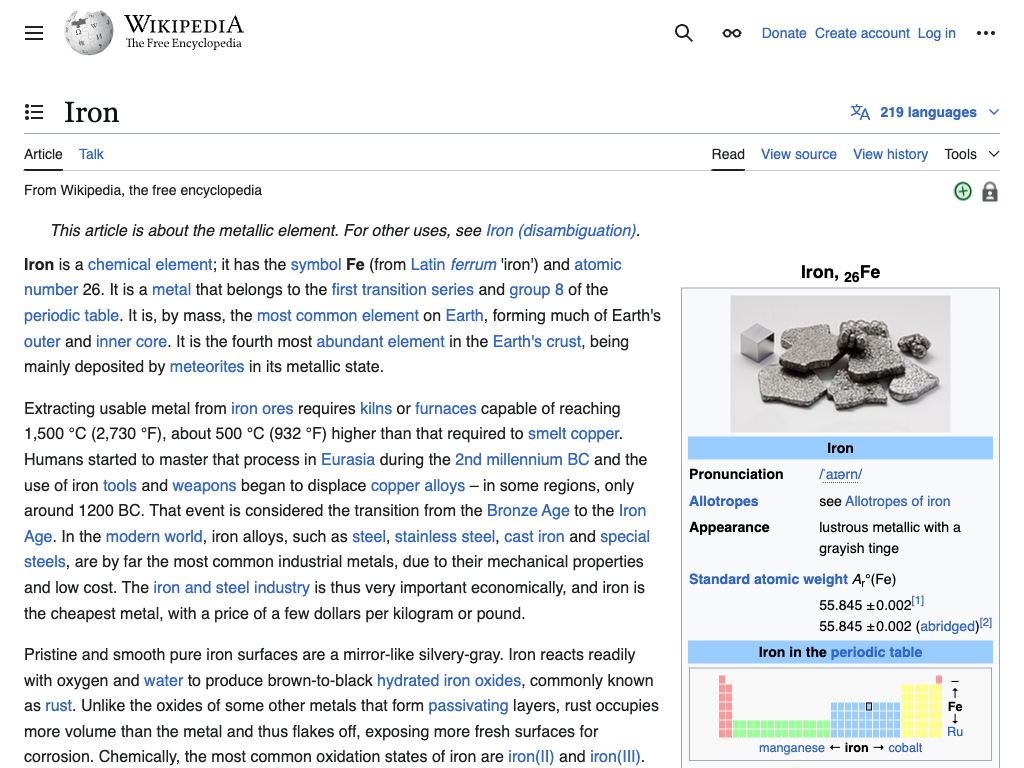



---

#### 🤖 Assistant

Looking at the Wikipedia page for Iron, I can see that iron's atomic number is 26. This can be found in several places on the page, including in the first paragraph where it states "Iron is a chemical element... number 26." Additionally, you can see it represented in the chemical notation on the right side of the page as "Iron, 26Fe".



---



In [7]:
user_message = input()
if len(user_message) > 0:
    messages.append({
        "role": "user",
        "content": user_message
    })
    await converse()
    

In [12]:
display_conversation_markdown(messages)

In [ ]:
await browser.close()
await playwright.stop()

In [ ]:
from computer_use_demo.utils.conversation_utils import save_conversation

save_conversation(messages, "outputs/americanino_with_xpath.json")

In [ ]:
from dotenv import load_dotenv
load_dotenv()
from computer_use_demo.utils.conversation_utils import load_conversation, replay_conversation

loaded = load_conversation("outputs/americanino_with_xpath.json")
loaded_playwright, browser, context, page, tools, tool_uses = await replay_conversation(
    loaded
)